# GCM Filters for POP tracer fields

This notebook has two main purposes:
* It illustrates how to use 5 different Laplacians to filter POP model output, and the differences between these filters.
* It does some **CPU** benchmarking tests to show how the filters differ in speed. (GPU tests are in a different notebook.)

In the following we use the gcm_filters code that lives on [this github branch](https://github.com/NoraLoose/gcm-filters/tree/POP-T-Laplacian).

In [1]:
import gcm_filters
import numpy as np
#import cupy as cp
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

These are all grid types that we have available so far:

In [2]:
list(gcm_filters.GridType)

[<GridType.CARTESIAN: 1>,
 <GridType.CARTESIAN_WITH_LAND: 2>,
 <GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>,
 <GridType.POP_SIMPLE_TRIPOLAR_T_GRID: 4>,
 <GridType.POP_TRIPOLAR_T_GRID: 5>]

For each of these 5 grid types, we have implemented a Laplacian that operates on the respective grid type. In this notebook, we will show that we can apply all 5 Laplacians to filter **tracer fields** from POP model output. The categories in which the 5 Laplacians differ are:
* complexity (rows in table below)
* filter type they can be used for (columns in table below)


| Laplacian | for filtering w/ fixed coarsening factor  | for filtering w/ fixed length scale|
| ----------- | ----------- | --------------|
| Ignores continental boundaries & tripolar exchanges      | `CARTESIAN`       ||
| Ignores tripolar exchanges  | `CARTESIAN_WITH_LAND`       | `IRREGULAR_CARTESIAN_WITH_LAND` |
| Handles everything (incl. continental boundaries & T-field tripolar exchanges)   | `POP_SIMPLE_TRIPOLAR_T_GRID`        | `POP_TRIPOLAR_T_GRID` |


* A filter with fixed filter length scale, e.g., `filter_scale = 100 km`, attempts to remove scales smaller than 100km.
* A filter with fixed coarsening factor, e.g., `filter_scale = 10`, attempts to remove scales smaller than 10 times the local grid scale. These filter types operate on uniform grids with dx = dy = 1.

### POP data

Open the POP 0.1 degree data that Ian saved.

In [3]:
ds = xr.open_dataset('/glade/work/igrooms/current_data', decode_times=False)

These are the important dimensions of our dataset:

In [4]:
Nt = np.size(ds.time)
Nz = np.size(ds.z_t)
Ny = np.size(ds.nlat)
Nx = np.size(ds.nlon)
print('Nt = %i, Nz = %i, Nx = %i, Ny = %i' %(Nt,Nz,Nx,Ny))

Nt = 1, Nz = 62, Nx = 3600, Ny = 2400


### Preparing the necessary grid information

The `CARTESIAN` Laplacian does not need any grid variables:

In [5]:
gcm_filters.required_grid_vars(gcm_filters.GridType.CARTESIAN)

[]

The `CARTESIAN_WITH_LAND` and `POP_SIMPLE_TRIPOLAR_T_GRID` Laplacians only need a `wet_mask` as a grid variable:

In [6]:
gcm_filters.required_grid_vars(gcm_filters.GridType.CARTESIAN_WITH_LAND)

['wet_mask']

In [7]:
gcm_filters.required_grid_vars(gcm_filters.GridType.POP_SIMPLE_TRIPOLAR_T_GRID)

['wet_mask']

So let's create the `wet_mask`. This is a mask that takes 1's on ocean T-cells, and 0's on land T-cells.

In [8]:
wet_mask = xr.where(ds['KMT']>0,1,0)

Text(0.5, 1.0, 'wet_mask')

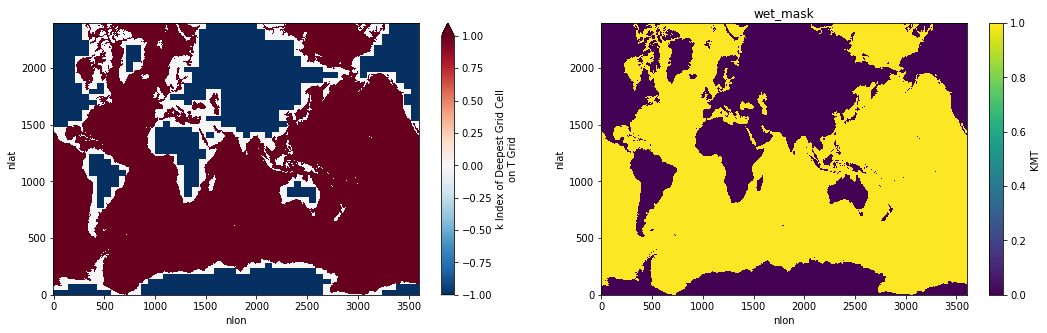

In [9]:
fig,axs = plt.subplots(1,2,figsize=(18,5))
ds.KMT.plot(ax=axs[0],vmin=ds.KMT.min())
wet_mask.plot(ax=axs[1])
axs[1].set_title('wet_mask')

The `IRREGULAR_CARTESIAN_WITH_LAND` and `POP_TRIPOLAR_T_GRID` Laplacians need a few more grid variables:

In [10]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area']

In [11]:
gcm_filters.required_grid_vars(gcm_filters.GridType.POP_TRIPOLAR_T_GRID)

['wet_mask', 'dxe', 'dye', 'dxn', 'dyn', 'tarea']

Let's start by creating the grid information for the `POP_TRIPOLAR_T_GRID` Laplacian, because the grid variables are directly available from POP's model diagnostics:

In [12]:
dxe = ds.HUS.where(wet_mask)/100  # x-spacing centered at eastern T-cell edge in m
dye = ds.HTE.where(wet_mask)/100  # y-spacing centered at eastern T-cell edge in m
dxn = ds.HTN.where(wet_mask)/100  # x-spacing centered at northern T-cell edge in m
dyn = ds.HUW.where(wet_mask)/100  # y-spacing centered at northern T-cell edge in m
tarea = ds.TAREA.where(wet_mask)/10000  # cell area

The `IRREGULAR_CARTESIAN_WITH_LAND` Laplacian was coded for general irregular Cartesian grids and uses a south-west convention (rather than a north-east convention). In other words, it needs grid length information about the western and southern cell edge: `dxw`, `dyw`, `dxs`, `dys`. To get this grid information, we need to work a little bit harder than for the `POP_TRIPOLAR_T_GRID` Laplacian - but actually not too hard:

In [13]:
dxw = ds.HUS.roll(nlon=-1, roll_coords=False).where(wet_mask)/100  # x-spacing centered at western T-cell edge in m
dyw = ds.HTE.roll(nlon=-1, roll_coords=False).where(wet_mask)/100  # y-spacing centered at western T-cell edge in m
dxs = ds.HTN.roll(nlat=-1, roll_coords=False).where(wet_mask)/100  # x-spacing centered at southern T-cell edge in m
dys = ds.HUW.roll(nlat=-1, roll_coords=False).where(wet_mask)/100  # y-spacing centered at southern T-cell edge in m
area = tarea

Finally, the filters with fixed filter length scale will have to know what the minimum grid spacing is in our model: about 2.2 km

In [14]:
dx_min_POP = min(dxe.min(),dye.min(),dxn.min(),dyn.min())
dx_min_POP = dx_min_POP.values
dx_min_POP

array(2245.78304344)

### Creating the 5 filters to be compared

First, we create three filters with **fixed coarsening factor** (left column in table above), and of increasing complexity. In all three cases, we choose `filter_scale = 10`, i.e., we attempt to remove scales smaller than 10 times the local grid scale. Note that the local grid scale is varying in space, but nomially 0.1 degree.
Moreover, we choose a Gaussian filter shape and 9 Laplacian steps (because this is approximately what Ian did in his fortran tests).

In [15]:
filter_scale = 10
n_steps = 9
filter_shape = gcm_filters.FilterShape.GAUSSIAN

In [16]:
filter_cartesian = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=1,
    filter_shape=filter_shape,
    n_steps=n_steps,
    grid_type=gcm_filters.GridType.CARTESIAN,
    grid_vars={}
)
filter_cartesian

n_steps = 9


Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=9, grid_type=<GridType.CARTESIAN: 1>)

In [17]:
filter_cartesian_with_land = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=1,
    filter_shape=filter_shape,
    n_steps=n_steps,
    grid_type=gcm_filters.GridType.CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_cartesian_with_land

n_steps = 9


Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=9, grid_type=<GridType.CARTESIAN_WITH_LAND: 2>)

In [18]:
filter_simple_pop_tripolar_grid = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=1,
    filter_shape=filter_shape,
    n_steps=n_steps,
    grid_type=gcm_filters.GridType.POP_SIMPLE_TRIPOLAR_T_GRID,
    grid_vars={'wet_mask': wet_mask}
)
filter_simple_pop_tripolar_grid

n_steps = 9


Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=9, grid_type=<GridType.POP_SIMPLE_TRIPOLAR_T_GRID: 4>)

The next two filters are for filtering with **fixed length scale** (right column in table above), and again of increasing complexity. For both filters, we pick a filter length scale of **111.7 km**, equal to one degree of latitude. That is, we attempt to remove scales smaller than 111.7 km.

In [21]:
filter_scale = 111700 
filter_shape = gcm_filters.FilterShape.GAUSSIAN

In [22]:
filter_irregular_cartesian_with_land = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min_POP,
    filter_shape=filter_shape,
    n_steps=0,  # default number of steps
    grid_type=gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area}
)
filter_irregular_cartesian_with_land

n_steps = 90


Filter(filter_scale=111700, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>)

In [23]:
filter_pop_tripolar_grid = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min_POP,
    filter_shape=filter_shape,
    n_steps=0,  # default number of steps
    grid_type=gcm_filters.GridType.POP_TRIPOLAR_T_GRID,
    grid_vars={'wet_mask': wet_mask, 'dxe': dxe, 'dye': dye, 'dxn': dxn, 'dyn': dyn, 'tarea': tarea}
)
filter_pop_tripolar_grid

n_steps = 90


Filter(filter_scale=111700, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.POP_TRIPOLAR_T_GRID: 5>)

In the last two filters, we chose `n_steps` to be the default number of Laplacian steps, equal to `n_steps=90`. We will create two more filters, which are identical to these two, but choosing `n_steps=9`. This latter choice will lead to a terrible approximation of our target filter, but we will include them in our timing tests anyway, to have a more direct comparison to the first three (fixed factor) filters.

In [24]:
filter_scale = 111700 
filter_shape = gcm_filters.FilterShape.GAUSSIAN
n_steps = 9

In [25]:
filter_irregular_cartesian_with_land_9steps = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min_POP,
    filter_shape=filter_shape,
    n_steps=n_steps,  
    grid_type=gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area}
)
filter_irregular_cartesian_with_land_9steps

n_steps = 9


Filter(filter_scale=111700, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=9, grid_type=<GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>)

In [26]:
filter_pop_tripolar_grid_9steps = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min_POP,
    filter_shape=filter_shape,
    n_steps=n_steps,  
    grid_type=gcm_filters.GridType.POP_TRIPOLAR_T_GRID,
    grid_vars={'wet_mask': wet_mask, 'dxe': dxe, 'dye': dye, 'dxn': dxn, 'dyn': dyn, 'tarea': tarea}
)
filter_pop_tripolar_grid_9steps

n_steps = 9


Filter(filter_scale=111700, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=9, grid_type=<GridType.POP_TRIPOLAR_T_GRID: 5>)

## Testing the exchanges across the northern tripolar grid boundary

We define two discrete delta functions deployed close to the northern boundary. The first one gets assigned positive mass (=1), the second one gets assigned negative mass (=-1).

In [27]:
delta1 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta1[2399,900] = 1
delta1 = delta1.where(wet_mask)

delta2 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta2[2399,2500] = -1
delta2 = delta2.where(wet_mask)

We now apply our filters to these delta functions.

In [28]:
# filter with fixed coarsening factor
delta1_filtered_cartesian_with_land = filter_cartesian_with_land.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_cartesian_with_land = filter_cartesian_with_land.apply(delta2, dims=['nlat', 'nlon'])

delta1_filtered_simple_pop_tripolar_grid = filter_simple_pop_tripolar_grid.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_simple_pop_tripolar_grid = filter_simple_pop_tripolar_grid.apply(delta2, dims=['nlat', 'nlon'])

# filter with fixed length scale
delta1_irregular_cartesian_with_land = filter_irregular_cartesian_with_land.apply(delta1, dims=['nlat', 'nlon'])
delta2_irregular_cartesian_with_land = filter_irregular_cartesian_with_land.apply(delta2, dims=['nlat', 'nlon'])

delta1_filtered_pop_tripolar_grid = filter_pop_tripolar_grid.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_pop_tripolar_grid = filter_pop_tripolar_grid.apply(delta2, dims=['nlat', 'nlon'])

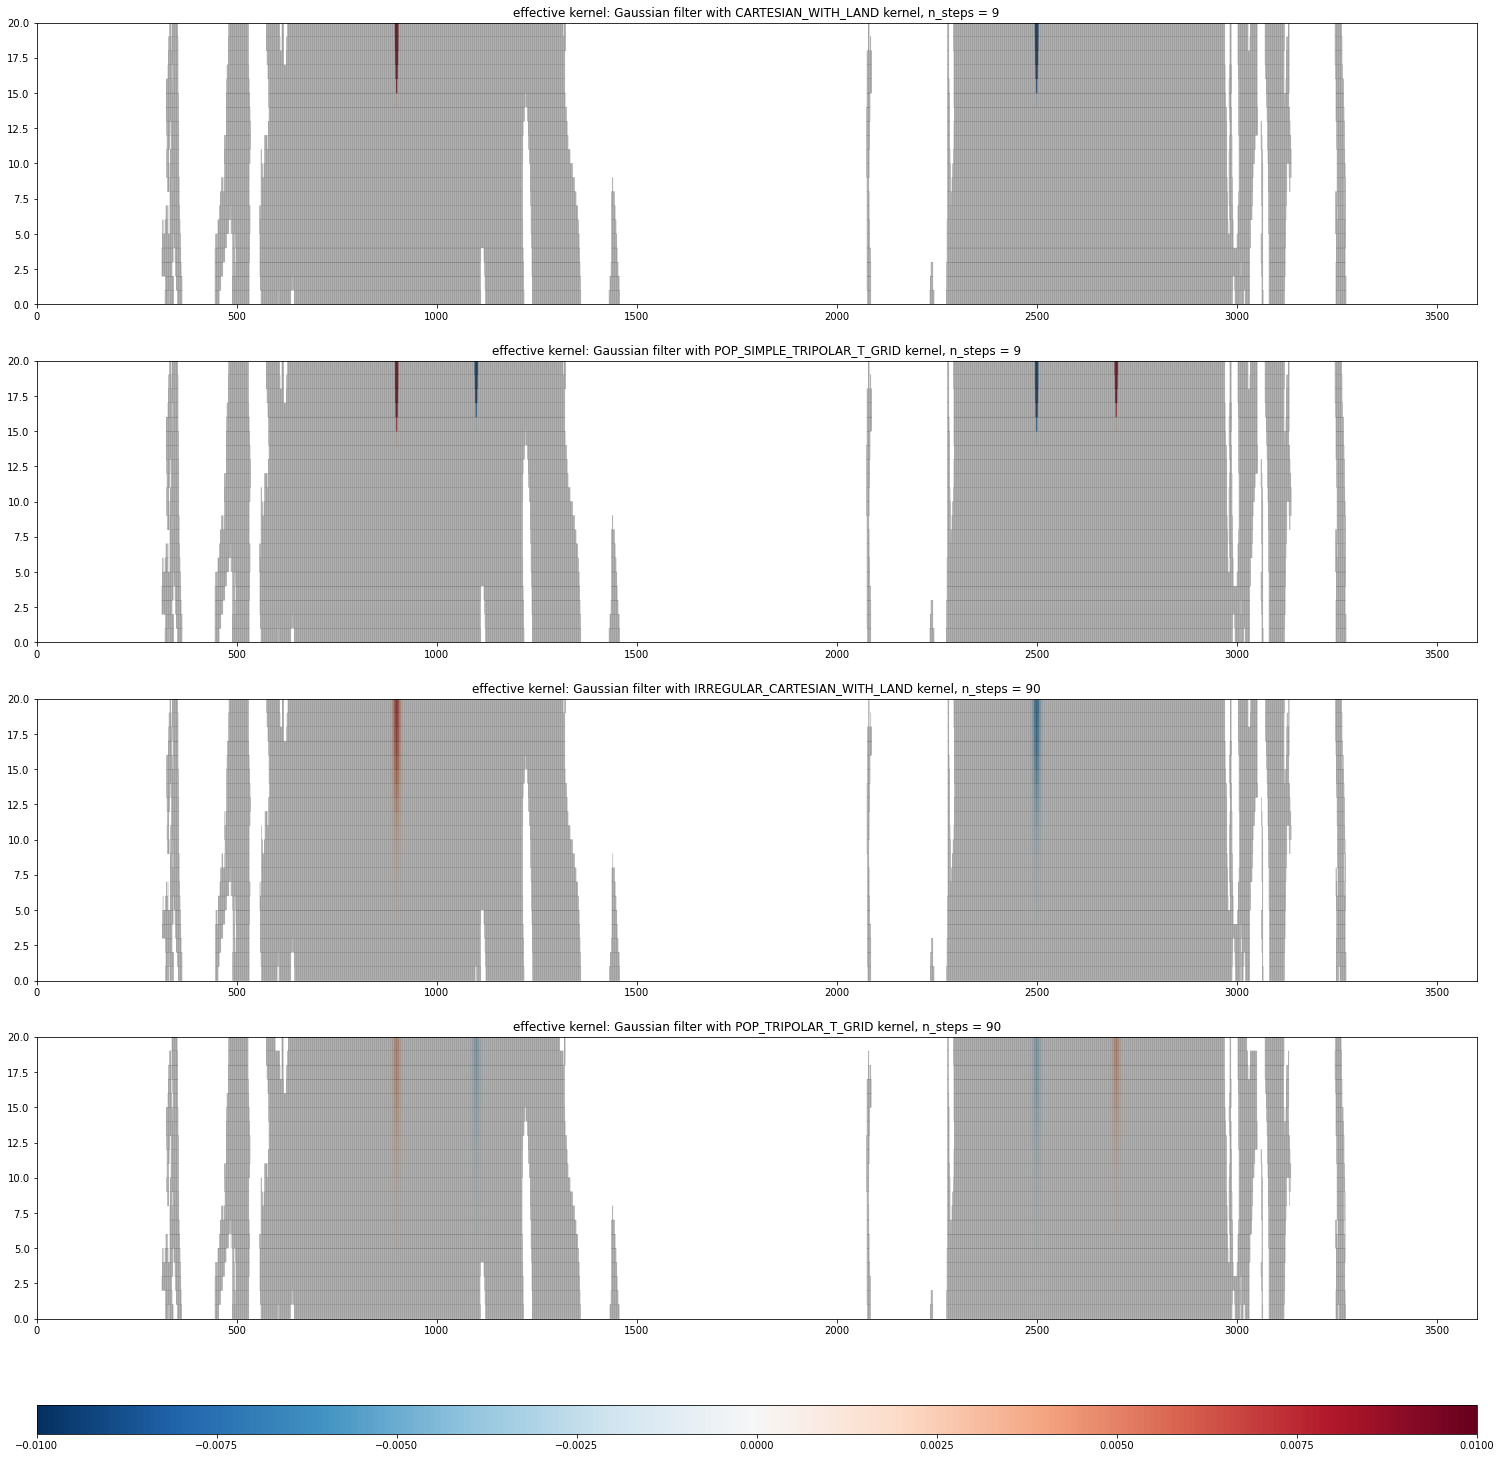

In [30]:
yslice = slice(2380,None)
vmin = -0.01
vmax = 0.01

fig,axs = plt.subplots(4,1,figsize=(25,20))
        
axs[0].pcolor((delta1_filtered_cartesian_with_land + delta2_filtered_cartesian_with_land).isel(nlat=yslice),
              cmap='RdBu_r',
              vmin=vmin,vmax=vmax,
              edgecolors='k', linewidths=0.1)
axs[1].pcolor((delta1_filtered_simple_pop_tripolar_grid + delta2_filtered_simple_pop_tripolar_grid).isel(nlat=yslice),
                    cmap='RdBu_r',
                    vmin=vmin,vmax=vmax,
                    edgecolors='k', linewidths=0.1)

axs[2].pcolor((delta1_irregular_cartesian_with_land + delta2_irregular_cartesian_with_land).isel(nlat=yslice),
                    cmap='RdBu_r',
                    vmin=vmin,vmax=vmax,
                    edgecolors='k', linewidths=0.1)

p = axs[3].pcolor((delta1_filtered_pop_tripolar_grid + delta2_filtered_pop_tripolar_grid).isel(nlat=yslice),
                    cmap='RdBu_r',
                    vmin=vmin,vmax=vmax,
                    edgecolors='k', linewidths=0.1)

axs[0].set(title='effective kernel: Gaussian filter with CARTESIAN_WITH_LAND kernel, n_steps = 9')
axs[1].set(title='effective kernel: Gaussian filter with POP_SIMPLE_TRIPOLAR_T_GRID kernel, n_steps = 9')
axs[2].set(title='effective kernel: Gaussian filter with IRREGULAR_CARTESIAN_WITH_LAND kernel, n_steps = 90')
axs[3].set(title='effective kernel: Gaussian filter with POP_TRIPOLAR_T_GRID kernel, n_steps = 90')

# colorbar
fig.subplots_adjust(left=0.1, bottom=-0.02)
cax = fig.add_axes([0.1, -0.1, 0.8, 0.02])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal')

All four panels show the 20 uppermost rows of the POP grid (a subset of the distorted Arctic). The **second and fourth panels** confirm that the `POP_SIMPLE_TRIPOLAR_T_GRID` and `POP_TRIPOLAR_T_GRID` allow exchanges across the northern boundary fold, both 
* from left to right (red shading, originating from `delta1` deployed with `mass = 1` in left part of domain); and 
* from right to left (blue shading, originating from `delta2` deployed with `mass = -1` in right part of domain). 

The **first and third panels** show that the `CARTESIAN_WITH_LAND` and `IRREGULAR_CARTESIAN_WITH_LAND` Laplacians do not allow exchanges across the northern boundary fold (as expected). Also note that the amplitudes of the diffused delta functions in panel 3 are stronger than in panel 4. This is due to the fact that `IRREGULAR_CARTESIAN_WITH_LAND` thinks that the northern boundary is land (because the southernmost row of `wet_mask` consists of zeros: Antarctica), and the effective kernel changes shape close to the continental boundaries. Loosely speaking, the effective kernel reflects back into the ocean if it hits continental boundaries.

The next two plots show the effective kernels of the `IRREGULAR_CARTESIAN_WITH_LAND` and `POP_TRIPOLAR_T_GRID` Laplacians, but with `n_steps=9` (rather than `n_steps=90`).

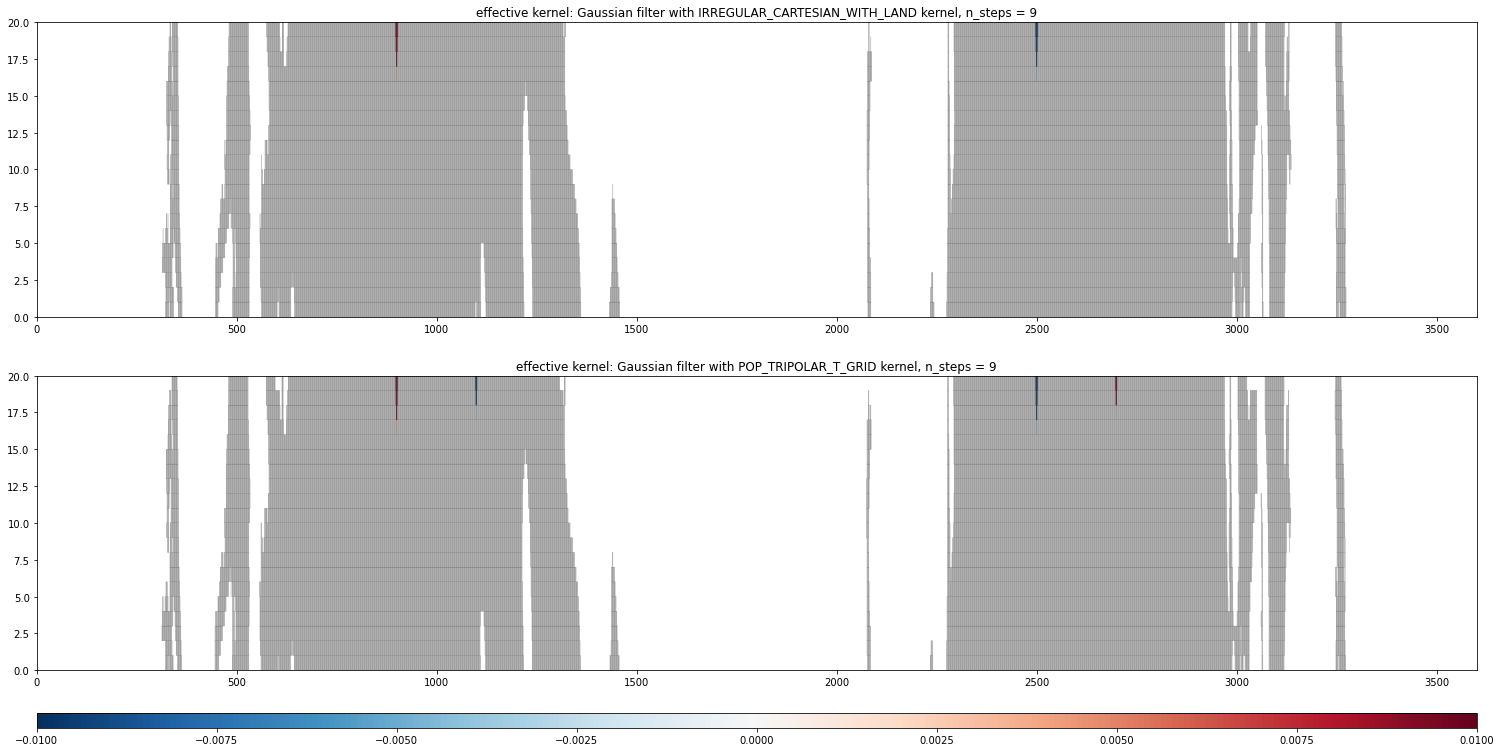

In [31]:
# filter with fixed length scale, n_step = 9
delta1_irregular_cartesian_with_land_9steps = filter_irregular_cartesian_with_land_9steps.apply(delta1, dims=['nlat', 'nlon'])
delta2_irregular_cartesian_with_land_9steps = filter_irregular_cartesian_with_land_9steps.apply(delta2, dims=['nlat', 'nlon'])

delta1_filtered_pop_tripolar_grid_9steps = filter_pop_tripolar_grid_9steps.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_pop_tripolar_grid_9steps = filter_pop_tripolar_grid_9steps.apply(delta2, dims=['nlat', 'nlon'])

yslice = slice(2380,None)
vmin = -0.01
vmax = 0.01

fig,axs = plt.subplots(2,1,figsize=(25,10))

axs[0].pcolor((delta1_irregular_cartesian_with_land_9steps + delta2_irregular_cartesian_with_land_9steps).isel(nlat=yslice),
                    cmap='RdBu_r',
                    vmin=vmin,vmax=vmax,
                    edgecolors='k', linewidths=0.1)

p = axs[1].pcolor((delta1_filtered_pop_tripolar_grid_9steps + delta2_filtered_pop_tripolar_grid_9steps).isel(nlat=yslice),
                    cmap='RdBu_r',
                    vmin=vmin,vmax=vmax,
                    edgecolors='k', linewidths=0.1)

axs[0].set(title='effective kernel: Gaussian filter with IRREGULAR_CARTESIAN_WITH_LAND kernel, n_steps = 9')
axs[1].set(title='effective kernel: Gaussian filter with POP_TRIPOLAR_T_GRID kernel, n_steps = 9')

# colorbar
fig.subplots_adjust(left=0.1, bottom=-0.02)
cax = fig.add_axes([0.1, -0.1, 0.8, 0.02])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal')

## Comparing the timing of the 5 (or 7) filters

We will compare the timing of the 5 Laplacians and filters on different levels of the code **on CPU**. We will go from high-level to low-level routines. **All timing results are summarized in the table at the end of this notebook.**

### High-level routines using Dask

We will time the filtering of
* 1 level of temperature data (`SST`), 
* 62 levels of temperature data (`TEMP`),

for all 5 filters with `n_steps=9`. The 2 filters with `n_steps=90` take too very long on a CPU, and are therefore only tested on `SST` but skipped for `TEMP`.

To take advantage of parallel lazy computation, we need to chunk up all our input arrays and turn them into Dask arrays:

In [115]:
SST = ds.TEMP.isel(z_t=0)
SST = SST.chunk({'nlat': Ny, 'nlon': Nx})  # 1 chunk
SST

<xarray.DataArray 'TEMP' (time: 1, nlat: 2400, nlon: 3600)>
dask.array<xarray-<this-array>, shape=(1, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 1.238e+04
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [116]:
TEMP = ds.TEMP.chunk({'z_t': 31})  # 2 chunks
TEMP

<xarray.DataArray 'TEMP' (time: 1, z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<xarray-<this-array>, shape=(1, 62, 2400, 3600), dtype=float32, chunksize=(1, 31, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 1.238e+04
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

### `SST`

`CARTESIAN, n_steps=9`

In [117]:
%time SST_filtered_cartesian = filter_cartesian.apply(SST, dims=['nlat', 'nlon'])

CPU times: user 2.61 ms, sys: 1.57 ms, total: 4.18 ms
Wall time: 4 ms


In [118]:
%time SST_filtered_cartesian_computed = SST_filtered_cartesian.compute()  # triggering computation

CPU times: user 1.37 s, sys: 697 ms, total: 2.06 s
Wall time: 1.21 s


`CARTESIAN_WITH_LAND, n_steps=9`

In [119]:
%time SST_filtered_cartesian_with_land = filter_cartesian_with_land.apply(SST, dims=['nlat', 'nlon'])

CPU times: user 973 ms, sys: 326 ms, total: 1.3 s
Wall time: 1.3 s


In [120]:
%time SST_filtered_cartesian_with_land_computed = SST_filtered_cartesian_with_land.compute()  # triggering computation

CPU times: user 1.9 s, sys: 1.3 s, total: 3.21 s
Wall time: 3.2 s


`POP_SIMPLE_TRIPOLAR_T_GRID, n_steps=9`

In [121]:
%time SST_filtered_simple_pop_tripolar_grid = filter_simple_pop_tripolar_grid.apply(SST, dims=['nlat', 'nlon'])

CPU times: user 952 ms, sys: 346 ms, total: 1.3 s
Wall time: 1.3 s


In [122]:
%time SST_filtered_simple_pop_tripolar_grid_computed = SST_filtered_simple_pop_tripolar_grid.compute()  # triggering computation

CPU times: user 2.04 s, sys: 1.46 s, total: 3.5 s
Wall time: 3.5 s


`IRREGULAR_CARTESIAN_WITH_LAND`

`n_steps=90`

In [123]:
%time SST_filtered_irregular_cartesian_with_land = filter_irregular_cartesian_with_land.apply(SST, dims=['nlat', 'nlon'])

CPU times: user 1.41 s, sys: 307 ms, total: 1.72 s
Wall time: 1.71 s


In [124]:
%time SST_filtered_irregular_cartesian_with_land_computed = SST_filtered_irregular_cartesian_with_land.compute()  # triggering computation

CPU times: user 20.3 s, sys: 16.6 s, total: 36.9 s
Wall time: 36.8 s


`n_steps=9`

In [125]:
%time SST_filtered_irregular_cartesian_with_land_9steps = filter_irregular_cartesian_with_land_9steps.apply(SST, dims=['nlat', 'nlon'])

CPU times: user 1.41 s, sys: 292 ms, total: 1.7 s
Wall time: 1.7 s


In [126]:
%time SST_filtered_irregular_cartesian_with_land_9steps_computed = SST_filtered_irregular_cartesian_with_land_9steps.compute()  # triggering computation

CPU times: user 2.21 s, sys: 1.77 s, total: 3.97 s
Wall time: 3.97 s


`POP_TRIPOLAR_T_GRID`

`n_steps=90`

In [127]:
%time SST_filtered_pop_tripolar_grid = filter_pop_tripolar_grid.apply(SST, dims=['nlat', 'nlon'])

CPU times: user 1.41 s, sys: 284 ms, total: 1.69 s
Wall time: 1.69 s


In [128]:
%time SST_filtered_pop_tripolar_grid_computed = SST_filtered_pop_tripolar_grid.compute()  # triggering computation

CPU times: user 21.1 s, sys: 16.9 s, total: 38 s
Wall time: 38 s


`n_steps=9`

In [129]:
%time SST_filtered_pop_tripolar_grid_9steps = filter_pop_tripolar_grid_9steps.apply(SST, dims=['nlat', 'nlon'])

CPU times: user 1.41 s, sys: 278 ms, total: 1.69 s
Wall time: 1.69 s


In [130]:
%time SST_filtered_pop_tripolar_grid_9steps_computed = SST_filtered_pop_tripolar_grid_9steps.compute()  # triggering computation

CPU times: user 2.33 s, sys: 1.89 s, total: 4.22 s
Wall time: 4.21 s


### `TEMP`

`CARTESIAN, n_steps=9`

In [131]:
%time TEMP_filtered_cartesian = filter_cartesian.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 3.67 ms, sys: 1.21 ms, total: 4.88 ms
Wall time: 4.71 ms


In [132]:
%time TEMP_filtered_cartesian_computed = TEMP_filtered_cartesian.compute()  # triggering computation

CPU times: user 1min 4s, sys: 32.8 s, total: 1min 37s
Wall time: 51.1 s


`CARTESIAN_WITH_LAND, n_steps=9`

In [133]:
%time TEMP_filtered_cartesian_with_land = filter_cartesian_with_land.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 944 ms, sys: 355 ms, total: 1.3 s
Wall time: 1.3 s


In [134]:
%time TEMP_filtered_cartesian_with_land_computed = TEMP_filtered_cartesian_with_land.compute()  # triggering computation

CPU times: user 3min 12s, sys: 1min 31s, total: 4min 43s
Wall time: 2min 24s


`POP_SIMPLE_TRIPOLAR_T_GRID, n_steps=9`

In [135]:
%time TEMP_filtered_simple_pop_tripolar_grid = filter_simple_pop_tripolar_grid.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 945 ms, sys: 351 ms, total: 1.3 s
Wall time: 1.29 s


In [136]:
%time TEMP_filtered_simple_pop_tripolar_grid_computed = TEMP_filtered_simple_pop_tripolar_grid.compute()  # triggering computation

CPU times: user 3min 23s, sys: 1min 39s, total: 5min 3s
Wall time: 2min 35s


`IRREGULAR_CARTESIAN_WITH_LAND`

`n_steps=90`

In [137]:
#%time TEMP_filtered_irregular_cartesian_with_land = filter_irregular_cartesian_with_land.apply(TEMP, dims=['nlat', 'nlon'])

In [138]:
#%time TEMP_filtered_irregular_cartesian_with_land_computed = TEMP_filtered_irregular_cartesian_with_land.compute()  # triggering computation

`n_steps=9`

In [139]:
%time TEMP_filtered_irregular_cartesian_with_land_9steps = filter_irregular_cartesian_with_land_9steps.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 1.41 s, sys: 273 ms, total: 1.69 s
Wall time: 1.69 s


In [140]:
%time TEMP_filtered_irregular_cartesian_with_land_9steps_computed = TEMP_filtered_irregular_cartesian_with_land_9steps.compute()  # triggering computation

CPU times: user 3min 51s, sys: 2min 10s, total: 6min 1s
Wall time: 3min 4s


`POP_TRIPOLAR_T_GRID`

`n_steps=90`

In [141]:
#%time TEMP_filtered_pop_tripolar_grid = filter_pop_tripolar_grid.apply(TEMP, dims=['nlat', 'nlon'])

In [142]:
#%time TEMP_filtered_pop_tripolar_grid_computed = TEMP_filtered_pop_tripolar_grid.compute()  # triggering computation

`n_steps=9`

In [143]:
%time TEMP_filtered_pop_tripolar_grid_9steps = filter_pop_tripolar_grid_9steps.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 1.41 s, sys: 278 ms, total: 1.69 s
Wall time: 1.69 s


In [144]:
%time TEMP_filtered_pop_tripolar_grid_computed_9steps = TEMP_filtered_pop_tripolar_grid_9steps.compute()  # triggering computation

CPU times: user 3min 59s, sys: 2min 14s, total: 6min 14s
Wall time: 3min 10s


### Low-level routines

The numbers in the tests above include the time to load the data from disk. Next, we load everything into memory as numpy arrays, thus bypassing xarray. This will also tell us how long the **loading of the data** takes - a number that can then be subtracted from the numbers above.

In [82]:
%time SST_raw = SST.values

CPU times: user 61.2 ms, sys: 29 ms, total: 90.1 ms
Wall time: 90.4 ms


In [83]:
%time TEMP_raw = TEMP.values

CPU times: user 4.95 s, sys: 1.71 s, total: 6.66 s
Wall time: 5.59 s


Loading the 2D grid fields should take about the same time for each of these:

In [84]:
%time dxe_raw = dxe.values

CPU times: user 11 µs, sys: 6 µs, total: 17 µs
Wall time: 19.8 µs


In [85]:
%time dye_raw = dye.values

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 17.4 µs


In [86]:
%time dxn_raw = dxn.values

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 13.8 µs


In [87]:
%time dyn_raw = dyn.values

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 11.9 µs


In [88]:
%time tarea_raw = tarea.values

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 11.9 µs


In [89]:
%time dxw_raw = dxw.values

CPU times: user 5 µs, sys: 3 µs, total: 8 µs
Wall time: 11 µs


In [90]:
%time dyw_raw = dyw.values

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 10.7 µs


In [91]:
%time dxs_raw = dxs.values

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 11.2 µs


In [92]:
%time dys_raw = dys.values

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 10.7 µs


In [93]:
%time area_raw = area.values

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 10.5 µs


In [94]:
%time wet_mask_raw = wet_mask.values

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 11.2 µs


For each of the 5 Laplacians, we will perform two timing tests:
* 1) Apply filter by calling the low-level routine, i.e., using just numpy rather than xarray and dask.
* 2) Apply Laplacian only **once** (rather than `n_steps` times as done in filter routine).

In [95]:
from gcm_filters.filter import _create_filter_func

`CARTESIAN, n_steps=9`

In [96]:
filter_func = _create_filter_func(filter_cartesian.filter_spec, filter_cartesian.Laplacian)  
%time filter_func(SST_raw)

CPU times: user 538 ms, sys: 339 ms, total: 877 ms
Wall time: 875 ms


array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)

In [97]:
laplacian = filter_cartesian.Laplacian()
%time _ = laplacian(SST_raw)

CPU times: user 52.1 ms, sys: 52.7 ms, total: 105 ms
Wall time: 103 ms


`CARTESIAN_WITH_LAND, n_steps=9`

In [98]:
filter_func = _create_filter_func(filter_cartesian_with_land.filter_spec, filter_cartesian_with_land.Laplacian) 
%time filter_func(SST_raw, wet_mask_raw)

CPU times: user 1.89 s, sys: 1.27 s, total: 3.16 s
Wall time: 3.15 s


array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)

In [99]:
laplacian = filter_cartesian_with_land.Laplacian(wet_mask=wet_mask_raw)
%time _ = laplacian(SST_raw)

CPU times: user 179 ms, sys: 120 ms, total: 299 ms
Wall time: 298 ms


`POP_SIMPLE_TRIPOLAR_T_GRID, n_steps=9`

In [100]:
filter_func = _create_filter_func(filter_simple_pop_tripolar_grid.filter_spec, filter_simple_pop_tripolar_grid.Laplacian) 
%time filter_func(SST_raw, wet_mask_raw)

CPU times: user 2.04 s, sys: 1.38 s, total: 3.43 s
Wall time: 3.43 s


array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)

In [101]:
laplacian = filter_simple_pop_tripolar_grid.Laplacian(wet_mask=wet_mask_raw)
%time _ = laplacian(SST_raw)

CPU times: user 194 ms, sys: 137 ms, total: 331 ms
Wall time: 331 ms


`IRREGULAR_CARTESIAN_WITH_LAND`

`n_steps=90`

In [105]:
filter_func = _create_filter_func(filter_irregular_cartesian_with_land.filter_spec, filter_irregular_cartesian_with_land.Laplacian) 
%time filter_func(SST_raw, wet_mask_raw, dxw_raw, dyw_raw, dxs_raw, dys_raw, area_raw)

CPU times: user 20.5 s, sys: 16.3 s, total: 36.8 s
Wall time: 36.8 s


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

`n_steps=9`

In [106]:
filter_func = _create_filter_func(filter_irregular_cartesian_with_land_9steps.filter_spec, filter_irregular_cartesian_with_land_9steps.Laplacian) 
%time filter_func(SST_raw, wet_mask_raw, dxw_raw, dyw_raw, dxs_raw, dys_raw, area_raw)

CPU times: user 2.14 s, sys: 1.65 s, total: 3.79 s
Wall time: 3.78 s


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [108]:
laplacian = filter_irregular_cartesian_with_land.Laplacian(
    wet_mask=wet_mask_raw, 
    dxw=dxw_raw,
    dyw=dyw_raw,
    dxs=dxs_raw,
    dys=dys_raw,
    area=area_raw
)
%time _ = laplacian(SST_raw)

CPU times: user 196 ms, sys: 173 ms, total: 370 ms
Wall time: 369 ms


`POP_TRIPOLAR_T_GRID`

`n_steps=90`

In [111]:
filter_func = _create_filter_func(filter_pop_tripolar_grid.filter_spec, filter_pop_tripolar_grid.Laplacian) 
%time filter_func(SST_raw, wet_mask_raw, dxe_raw, dye_raw, dxn_raw, dyn_raw, tarea_raw)

CPU times: user 22.1 s, sys: 16.8 s, total: 38.9 s
Wall time: 38.9 s


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

`n_steps=9`

In [113]:
filter_func = _create_filter_func(filter_pop_tripolar_grid_9steps.filter_spec, filter_pop_tripolar_grid_9steps.Laplacian) 
%time filter_func(SST_raw, wet_mask_raw, dxe_raw, dye_raw, dxn_raw, dyn_raw, tarea_raw)

CPU times: user 2.31 s, sys: 1.74 s, total: 4.05 s
Wall time: 4.05 s


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [114]:
laplacian = filter_pop_tripolar_grid_9steps.Laplacian(
    wet_mask=wet_mask_raw, 
    dxe=dxe_raw,
    dye=dye_raw,
    dxn=dxn_raw,
    dyn=dyn_raw,
    tarea=tarea_raw
)
%time _ = laplacian(SST_raw)

CPU times: user 218 ms, sys: 171 ms, total: 389 ms
Wall time: 389 ms


### Summary of timing tests

| |`CARTESIAN` |`CARTESIAN_WITH_LAND` | `POP_SIMPLE_TRIPOLAR_T_GRID` | `IRREGULAR_CARTESIAN_WITH_LAND`  | `POP_TRIPOLAR_T_GRID`|
| ----------- | ----------- |----------- | ----------- | ----------- | --------------|
| **For which filter type?** | fixed factor| fixed factor | fixed factor | fixed scale | fixed scale |
| **Laplacian complexity** | Ignores continents & tripolar exchanges | Ignores tripolar exchanges | Handles everything | Ignores tripolar exchanges | Handles everything |
| ----------- | ----------- |----------- | ----------- | ----------- | --------------|
| **One Laplacian step (serial numpy, 1 depth level)**| CPU times: user 52.1 ms, sys: 52.7 ms, total: 105 ms; Wall time: 103 ms | CPU times: user 179 ms, sys: 120 ms, total: 299 ms; Wall time: 298 ms | CPU times: user 194 ms, sys: 137 ms, total: 331 ms; Wall time: 331 ms | CPU times: user 196 ms, sys: 173 ms, total: 370 ms; Wall time: 369 ms   |  CPU times: user 218 ms, sys: 171 ms, total: 389 ms; Wall time: 389 ms|
| **Full filter (serial numpy, 1 depth level)**| `n_steps=9`: CPU times: user 538 ms, sys: 339 ms, total: 877 ms; Wall time: 875 ms | `n_steps=9`: CPU times: user 1.89 s, sys: 1.27 s, total: 3.16 s; Wall time: 3.15 s | `n_steps=9`: CPU times: user 2.04 s, sys: 1.38 s, total: 3.43 s; Wall time: 3.43 s | `n_steps=9`: CPU times: user 2.14 s, sys: 1.65 s, total: 3.79 s; Wall time: 3.78 s | `n_steps=9`: CPU times: user 2.31 s, sys: 1.74 s, total: 4.05 s; Wall time: 4.05 s|
| | | |    | `n_steps=90`: CPU times: user 20.5 s, sys: 16.3 s, total: 36.8 s; Wall time: 36.8 s | `n_steps=90`: CPU times: user 22.1 s, sys: 16.8 s, total: 38.9 s; Wall time: 38.9 s |
| **Serial numpy + dask for parallelism (1 depth level)**; times are for triggering computation, don't include pre-applied filter.apply() method, but do include loading of data) | `n_steps=9`: CPU times: user 1.37 s, sys: 697 ms, total: 2.06 s; Wall time: 1.21 s| `n_steps=9`: CPU times: user 1.9 s, sys: 1.3 s, total: 3.21 s; Wall time: 3.2 s | `n_steps=9`: CPU times: user 2.04 s, sys: 1.46 s, total: 3.5 s; Wall time: 3.5 s | `n_steps=9`: CPU times: user 2.21 s, sys: 1.77 s, total: 3.97 s; Wall time: 3.97 s | `n_steps=9`: CPU times: user 2.21 s, sys: 1.77 s, total: 3.97 s; Wall time: 3.97 s |
| | | |    | `n_steps=90`: CPU times: user 20.3 s, sys: 16.6 s, total: 36.9 s; Wall time: 36.8 s | `n_steps=90`: CPU times: user 21.1 s, sys: 16.9 s, total: 38 s; Wall time: 38 s |
| **Serial numpy + dask for parallelism (62 depth levels)**; times are for triggering computation, don't include pre-applied filter.apply() method, but do include loading of data) | `n_steps=9`: CPU times: user 1min 4s, sys: 32.8 s, total: 1min 37s; Wall time: 51.1 s | `n_steps=9`: CPU times: user 3min 12s, sys: 1min 31s, total: 4min 43s; Wall time: 2min 24s| `n_steps=9`: CPU times: user 3min 23s, sys: 1min 39s, total: 5min 3s; Wall time: 2min 35s | `n_steps=9`: CPU times: user 3min 51s, sys: 2min 10s, total: 6min 1s; Wall time: 3min 4s | `n_steps=9`: CPU times: user 3min 59s, sys: 2min 14s, total: 6min 14s; Wall time: 3min 10s |
| **Time loading of data for 1 depth level** | `SST`: CPU times: user 61.2 ms, sys: 29 ms, total: 90.1 ms; Wall time: 90.4 ms | `SST`: see left | `SST`: see left | `SST`: see left | `SST`: see left |
| | | `wet_mask`: CPU times: user 11 µs, sys: 6 µs, total: 17 µs; Wall time: 19.8 µs  | `wet_mask`: see left  | `wet_mask`, `dxw`, `dyw`, `dxs`, `dys`, `area`: approximately 6x the times for `wet_mask`, see left | `wet_mask`, `dxe`, `dye`, `dxn`, `dyn`, `tarea`: approximately 6x the times for `wet_mask`, see left
| **Time loading of data for 62 depth levels** | `TEMP`: CPU times: user 4.95 s, sys: 1.71 s, total: 6.66 s; Wall time: 5.59 s | `TEMP`: see left | `TEMP`: see left | `TEMP`: see left | `TEMP`: see left | `TEMP`: see left |
| | | `wet_mask`: see above  | `wet_mask`: see above  | `wet_mask`, `dxw`, `dyw`, `dxs`, `dys`, `area`: see above | `wet_mask`, `dxe`, `dye`, `dxn`, `dyn`, `tarea`: see above